In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *

In [2]:
(xtrain,_),(xtest,_)=mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
xtrain=np.vstack([xtrain,xtest])
print(xtrain.shape)

(70000, 28, 28)


In [4]:
#Normalise Data between [-1,1]
# print(xtrain)
xtrain=(xtrain.astype('float32')-127.5)/127.5 #(0+255)/2=127.5
print(np.min(xtrain))
print(np.max(xtrain))
xtrain=xtrain.reshape((*xtrain.shape,1))
print(xtrain.shape)

-1.0
1.0
(70000, 28, 28, 1)


In [5]:
batch_size = 256
no_of_batches= int(xtrain.shape[0]/batch_size) 
half_batch = 128
noise_dim = 100 # 100 will be upscaled to 784 by generator
adam = Adam(lr=2e-4,beta_1=0.5)

## Model Architecture

### Generator

In [6]:
# Generator
generator=Sequential()
generator.add(Dense(7*7*128,input_shape=(noise_dim,)))
generator.add(Reshape((7,7,128)))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

#Double activation
generator.add(UpSampling2D())
generator.add(Conv2D(64,kernel_size=(5,5),padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

# Double the Activation Size 28 X 28 X 1
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))

# Final Output (No ReLu or Batch Norm)
generator.compile(loss='binary_crossentropy', optimizer=adam)
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0

## Discriminator

In [7]:
# Discriminator 
# Downsampling
discriminator = Sequential()
discriminator.add(Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=(28,28,1)))
discriminator.add(LeakyReLU(0.2))

# Prefer Strided Convolutions over MaxPooling
discriminator.add(Conv2D(128,(5,5),strides=(2,2),padding='same'))
discriminator.add(LeakyReLU(0.2))


discriminator.add(Flatten())
discriminator.add(Dense(1,activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy',optimizer=adam)
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6273      
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
________________________________________________

In [8]:
discriminator.trainable = False
GAN_input = Input(shape=(noise_dim,))
generated_img = generator(GAN_input)
GAN_output = discriminator(generated_img)

#Functional API
model = Model(GAN_input,GAN_output)
model.compile(loss='binary_crossentropy',optimizer=adam)

## Training

In [21]:
total_epoch=50
for epoch in range(1,total_epoch+1):
    discriminator_loss = 0.
    generator_loss = 0.
    for step in range(no_of_batches):
        #half real and half fake batch as input to discriminator
        idx = np.random.randint(0,xtrain.shape[0],half_batch)
        real_imgs = xtrain[idx]
        noise = np.random.normal(0,1,size=(half_batch,noise_dim))
        fake_imgs = generator.predict(noise)
        
        # one sided label smoothing works good in practice
        real_y = np.ones((half_batch,1))*0.9 
        fake_y = np.zeros((half_batch,1))
        
        # training Discriminator
        loss_real = discriminator.train_on_batch(real_imgs,real_y) 
        loss_fake = discriminator.train_on_batch(fake_imgs,fake_y) 
        discriminator_loss += (loss_real + loss_fake)/2.0
        
        
        # train Generator (Discriminator is Frozen)
        noise = np.random.normal(0,1,size=(batch_size,noise_dim))
        real_y = np.ones((batch_size,1))
        g_loss = model.train_on_batch(noise,real_y)
        generator_loss += g_loss

    print("Epoch %d D loss: %f G loss: %f" % (epoch,discriminator_loss, generator_loss))

Epoch 1 D loss: 187.037622 G loss: 226.829482
Epoch 2 D loss: 186.839893 G loss: 227.078842
Epoch 3 D loss: 186.795264 G loss: 227.176956
Epoch 4 D loss: 186.247210 G loss: 232.264147
Epoch 5 D loss: 186.562692 G loss: 227.428379
Epoch 6 D loss: 186.473976 G loss: 228.207890
Epoch 7 D loss: 186.283818 G loss: 229.126570
Epoch 8 D loss: 186.208883 G loss: 230.067156
Epoch 9 D loss: 185.860990 G loss: 233.033035
Epoch 10 D loss: 185.862067 G loss: 230.235045
Epoch 11 D loss: 185.706468 G loss: 231.144633
Epoch 12 D loss: 185.606664 G loss: 231.918430
Epoch 13 D loss: 185.325511 G loss: 235.275157
Epoch 14 D loss: 185.213559 G loss: 233.337279
Epoch 15 D loss: 185.044468 G loss: 233.634868
Epoch 16 D loss: 184.917969 G loss: 234.950841
Epoch 17 D loss: 184.753384 G loss: 235.356863
Epoch 18 D loss: 184.390009 G loss: 236.800403
Epoch 19 D loss: 184.334878 G loss: 237.462032
Epoch 20 D loss: 184.065358 G loss: 238.283371
Epoch 21 D loss: 183.884021 G loss: 238.743853
Epoch 22 D loss: 183.5

Both Generator and Discriminator have adversarial goals. Both get better with training so you can't expect the loss to be decreasing all the time. The Discriminator loss as seen in the above training is constantly decreasing but not the Generator loss. It is because Discriminator is learning fastly how to distinguish fake and real images and Generator is also improving but not able to fool the Discriminator but this is totally fine because in each epoch Generator is learning and It gets better.

In [22]:
generator.save('generator_model_weights.h5')

## Testing

In [46]:
noise=np.random.normal(0,1,(100,noise_dim))
new_imgs=generator.predict(noise)

In [47]:
new_imgs=new_imgs.reshape((100,28,28))

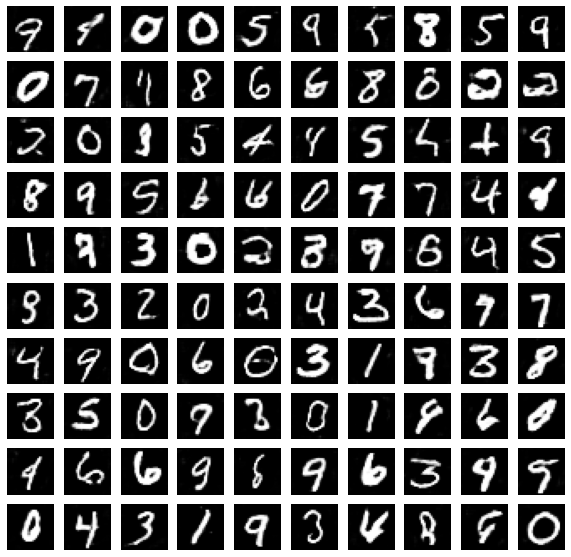

In [48]:
plt.figure(figsize=(10,10))
for i in range(100):
  plt.subplot(10,10,i+1)
  plt.imshow(new_imgs[i],cmap='gray')
  plt.axis('off')
plt.savefig('final_output.png')
plt.show()